## First run  tt serve-local -c src/ai2_internal/config.yaml -v figure_table_predictors to bring the service up

In [33]:
import pandas as pd
import json
import layoutparser.elements as lpe
import layoutparser.visualization as lpv
from collections import defaultdict
from PIL import Image
import os
from os import listdir

In [34]:
import os
import json

from typing import List

from mmda.types.document import Document
from mmda.types.annotation import Span, SpanGroup

from mmda.types.span import Span

from mmda.parsers.pdfplumber_parser import PDFPlumberParser
from mmda.rasterizers.rasterizer import PDF2ImageRasterizer
from mmda.predictors.lp_predictors import LayoutParserPredictor

import layoutparser.elements as lpe
import layoutparser.visualization as lpv
from typing import List


from mmda.predictors.hf_predictors.token_classification_predictor import (
    IVILATokenClassificationPredictor,
)

In [6]:
from mmda.recipes.core_recipe import CoreRecipe

In [25]:
recipe_doc = CoreRecipe()
doc = recipe_doc.from_path('./test_fixtures/test_doc_sha_d0450478c38dda61f9943f417ab9fcdb2ebeae0a.pdf')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 15/15 [01:03<00:00,  4.25s/it]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 15/15 [01:04<00:00,  4.27s/it]


In [26]:
import os
import requests
import json

In [10]:
from ai2_internal import api

In [11]:
from ai2_internal.figure_table_predictors.interface import Instance
from mmda.types.image import tobase64
from mmda.types.annotation import SpanGroup, BoxGroup

In [37]:
def process_table_figure(doc):
    #url='http://localhost:8080/invocations'
    url = 'http://mmda-figure-cap-pred.v2.prod.models.s2.allenai.org/invocations'
    tokens = [api.SpanGroup.from_mmda(sg) for sg in doc.tokens]
    rows = [api.SpanGroup.from_mmda(sg) for sg in doc.rows]
    pages = [api.SpanGroup.from_mmda(sg) for sg in doc.pages]
    vila_span_groups = [api.SpanGroup.from_mmda(sg) for sg in doc.vila_span_groups]
    layout = recipe_doc.effdet_publaynet_predictor.predict(document=doc)
    equations = recipe_doc.effdet_mfd_predictor.predict(document=doc)
    blocks = [api.BoxGroup.from_mmda(bg) for bg in layout + equations]
    pages = [api.SpanGroup.from_mmda(sg) for sg in doc.pages]
    images = [tobase64(image) for image in doc.images]
    data={
      "instances": [{
      "symbols": doc.symbols,
      "tokens": [token.dict() for token in tokens],
      "rows": [token.dict() for token in rows],
      "pages": [token.dict() for token in pages],
      "vila_span_groups": [token.dict() for token in vila_span_groups],
      "blocks": [token.dict() for token in blocks],
      "images": images}]}
    result = requests.post(url, json=data)
    result.raise_for_status()
    return result

In [38]:
result = process_table_figure(doc)

100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


In [39]:
figure_box_groups = [BoxGroup.from_json(figure) for figure in json.loads(result.text)['predictions'][0]['figures']]

for figure_box in figure_box_groups:
    figure_box.doc = doc

In [40]:
figure_caption_span_groups = [SpanGroup.from_json(figure_captions) for figure_captions in json.loads(result.text)['predictions'][0]['figure_captions']]

In [41]:
table_box_groups = [BoxGroup.from_json(table) for table in json.loads(result.text)['predictions'][0]['tables']]

for table_box in table_box_groups:
    table_box.doc = doc

In [42]:
table_caption_span_groups = [SpanGroup.from_json(table_captions) for table_captions in json.loads(result.text)['predictions'][0]['table_captions']]

In [44]:
def create_map_page_rectangle(list_box_group, doc):
    
    dictionary_of_boxes_object = defaultdict(list)
    for box_group in list_box_group:
        for box in box_group.boxes:
            dictionary_of_boxes_object[box.page].append(make_span_rectangle(box, doc.images[box.page - 1]))
    
    return dictionary_of_boxes_object


def make_span_rectangle(box, image):
    w, h = image.size
    return lpe.Rectangle(
                        box.l * w,
                        box.t * h,
                        (box.l + box.w) * w,
                        (box.t + box.h) * h
                    )

def draw_boxgroups_results(image, rectangle_list, color_map=None, draw_box=True):
    viz = []
    if color_map is None:
        color_map={'fig': 'green', 'fig_caption': 'blue', 'tab': 'yellow', 'tab_caption': 'pink'}

    for rectangle, color, text in rectangle_list:
        #print(rectangle, color, text)
        if isinstance(rectangle, tuple):
            viz.append(lpe.TextBlock(rectangle[0], type=color, text=rectangle[1]))
        else:
            viz.append(lpe.TextBlock(rectangle, type=color, text=text))
        
    if image:
        if draw_box:
            return lpv.draw_box(image, viz, color_map=color_map, show_element_type=True, 
                               id_font_size=8)
        else:
            return lpv.draw_text(image, viz, color_map=color_map, show_element_type=True, 
                                 id_font_size=8)
    return None

def draw_boxgroups(image, rectangle_list, color_map=None):
    viz = []
    if color_map is None:
        color_map={'color_Algorithm': 'green', 'color_Bibliography': 'blue', 'color_Caption': 'yellow', 'color_Figure': 'pink',
                   'color_Header': 'orange', 'color_Paragraph': 'red', 'color_Section': 'magenta'}
        
    for rectangle, text_type in rectangle_list:

        
        viz.append(lpe.TextBlock(rectangle, type=f'color_{text_type}'))
        
    if image:
        return lpv.draw_box(image, viz, color_map=color_map)
    return None

In [45]:
def make_list_of_captions(caption_predictions, doc):
    return [doc.symbols[span.start:span.end] for span_group in caption_predictions for span in span_group.spans]

In [46]:
def generate_mmda_figure_table_pdf(doc, figure_list, table_list, figure_captions, table_captions, 
                                   display_=False):

    dict_figure = create_map_page_rectangle(figure_list, doc)
    dict_table = create_map_page_rectangle(table_list, doc)
    
    results_rectangle = defaultdict(list)
    layout_parser_dict = defaultdict(list)
    layout_parser_dict_span = defaultdict(list)
    layout_parser_dict_box_group = defaultdict(list)
    
    for caption in make_list_of_captions(figure_captions, doc):
        print(caption)
    for caption in make_list_of_captions(table_captions, doc):
        print(caption)
    for page, image in enumerate(doc.images):
        rectangle_list = []
        
        if dict_figure.get(page):
            rectangle_list.extend([(entry, 'red',  'fig') for entry in dict_figure.get(page)])
        if dict_table.get(page):
            rectangle_list.extend([(entry, 'blue', 'tab')  for entry in dict_table.get(page)])

            
        #if dict_figure_caption_text.get(page):
        #    rectangle_text_list.extend([(entry, 'fig_caption', text)  for entry, text in dict_figure_caption_text.get(page)])
        
        #if dict_table_caption_text.get(page):
        #    rectangle_text_list.extend([(entry, 'tab_caption', text)  for entry, text in dict_table_caption_text.get(page)])
        
        for entry_caption in doc.vila_span_groups:
            for span_group in entry_caption.tokens:
                for span in span_group.spans:
                    if span.box.page == page:
                        results_rectangle[page].append((make_span_rectangle(span.box, image=image), entry_caption.type))

        # Get layoutparser boxes
        for entry_caption in doc.blocks:
            for span in entry_caption.spans:
                if span.box.page == page:
                    layout_parser_dict_span[page].append((make_span_rectangle(span.box, image=image), entry_caption.box_group.type))
        for entry_caption in doc.blocks:
            for box in entry_caption.box_group.boxes:
                if box.page == page:
                    layout_parser_dict_box_group[page].append((make_span_rectangle(box, image=image), entry_caption.box_group.type))

        image_pred = draw_boxgroups_results(image, rectangle_list)

        #if rectangle_text_list:
        #    image_with_text = draw_boxgroups_results(Image.new("RGB", image_pred.size, (255, 255, 255)), rectangle_text_list, draw_box=False)
        #else:
        #    image_with_text = None
        
        print(f'Page number {page}')
        print('Figure Table Service predictions')

        

        display(image_pred)
        #image_list.append(image_pred)
        #if image_with_text:
        #    display(image_with_text)
        #    image_list.append(image_with_text)
            

        if display_:
            print('********Vila span group boxes*********')
            display(draw_boxgroups(image, rectangle_list=results_rectangle[page]))
            color_map={'color_Figure': 'green', 'color_List': 'blue', 'color_Table': 'yellow', 'color_Text': 'pink',
                       'color_Title': 'orange',}
            print('********Layoutparser span group boxes*********')
            display(draw_boxgroups(image, rectangle_list=layout_parser_dict_span[page], color_map=color_map))
            print('========Layoutparser box group boxes===========')
            display(draw_boxgroups(image, rectangle_list=layout_parser_dict_box_group[page], color_map=color_map))
    
    #image_list_to_save = []
    #for idx, image in enumerate(image_list):
    #    background = Image.new("RGB", image.size, (255, 255, 255))
    #    if len(image.split()) > 4:
    #        background.paste(image, mask=image.split()[3])
    #    else:
    #        background.paste(image)
    #    image_list_to_save.append(background)

Figure 1. A few schemes of Smart Cities found online, in which people do not appear.
( a ) “Smart Cities Big Data Cycle” [14]; and ( b ) “Smart Cities: a System of Systems of
Systems” [15].
Figure 2. In recent years, finally the citizen is on these schemes. ( a ) “Infrastructures,
operations, people” [16]; and ( b ) “Smart Cities need smart citizens” [17].
Figure 3. Circular flow diagram between the needs and consequences of technological
application, based on social and individual demand.
Figure 4. Scheme showing dependencies between the different elements of analysis.
Figure 6. iiLUIX: how the system works [20].
Table 1. Technologies Analysis Matrix (TAM) main concepts and qualification.
Table 2. Technology X scoring process.
Table 3. Smart City final qualification Matrix (SCM).
Table 4. TAM applied to ii LUIX.
Table 5. SCM for Pamplona City strategy.
Table 6. Evaluation process.
Page number 0
Figure Table Service predictions


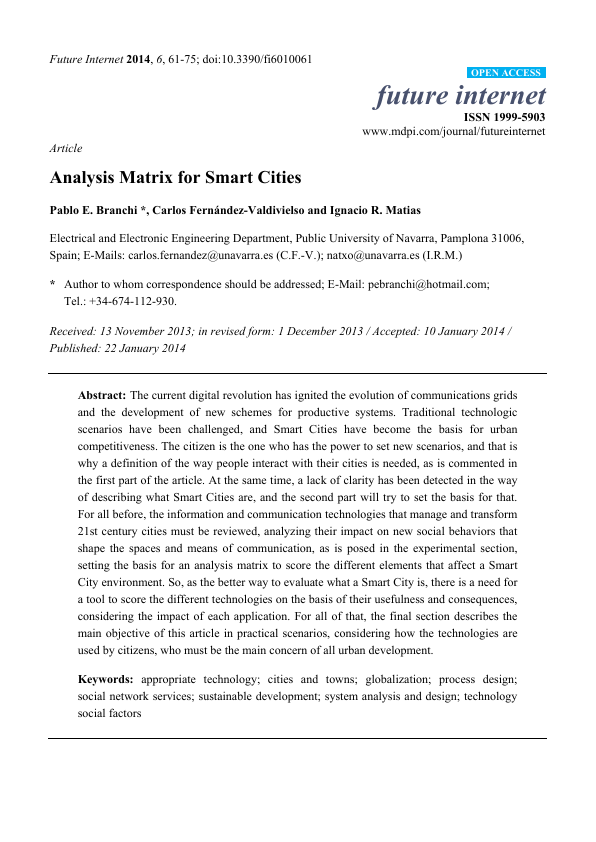

Page number 1
Figure Table Service predictions


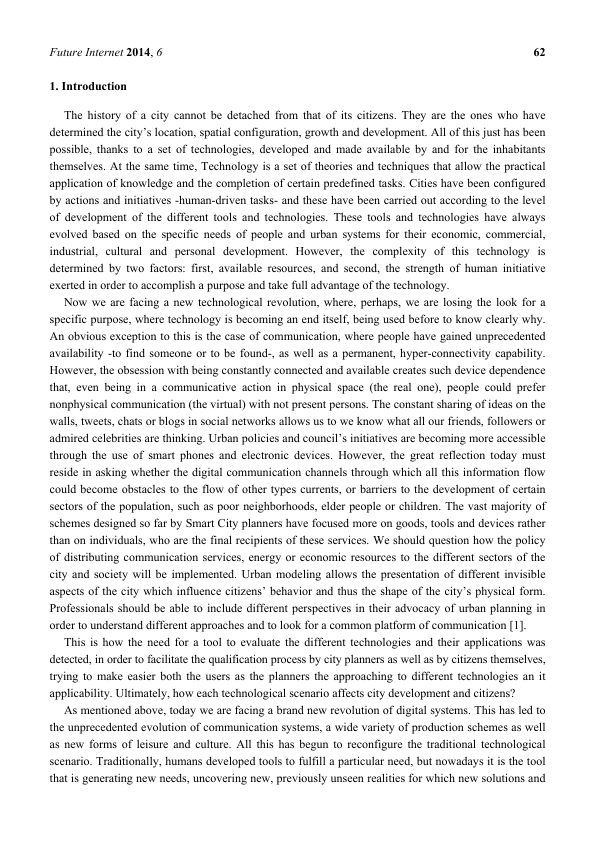

Page number 2
Figure Table Service predictions


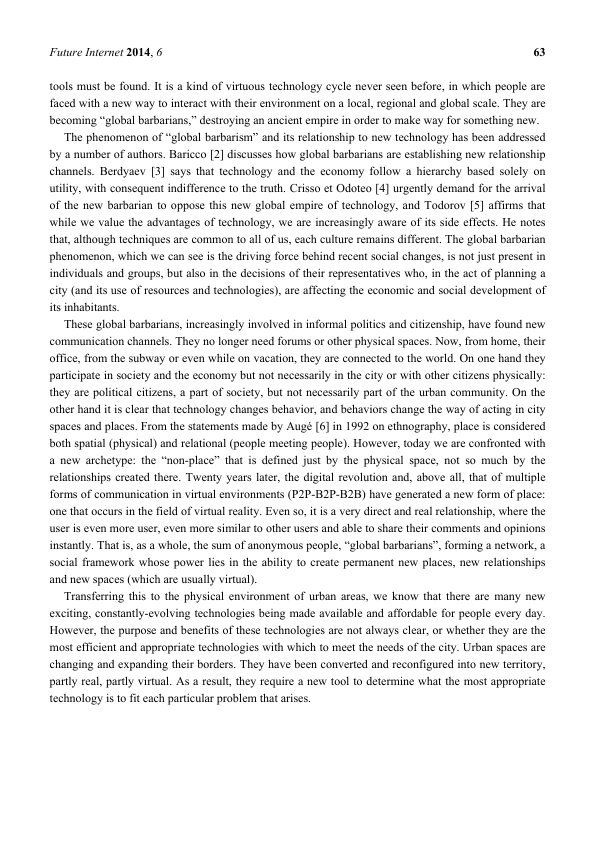

Page number 3
Figure Table Service predictions


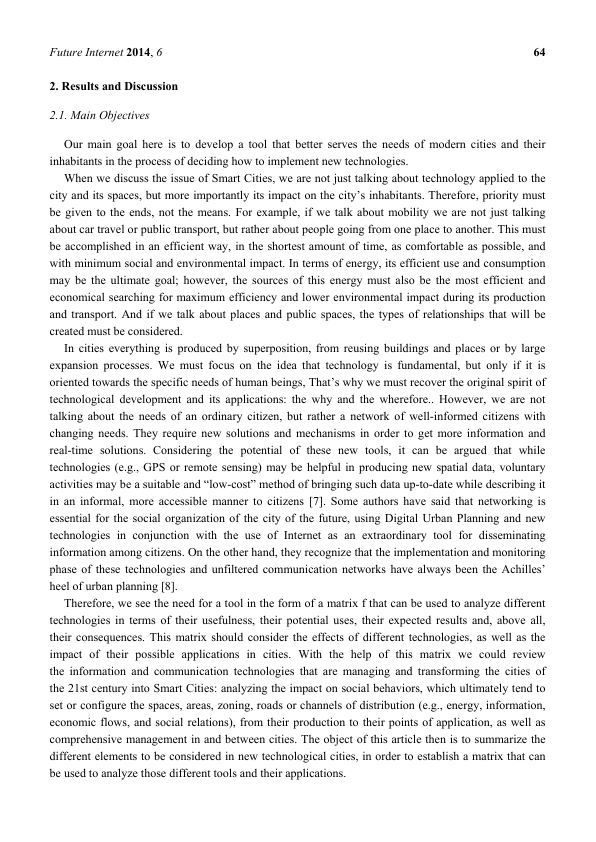

Page number 4
Figure Table Service predictions


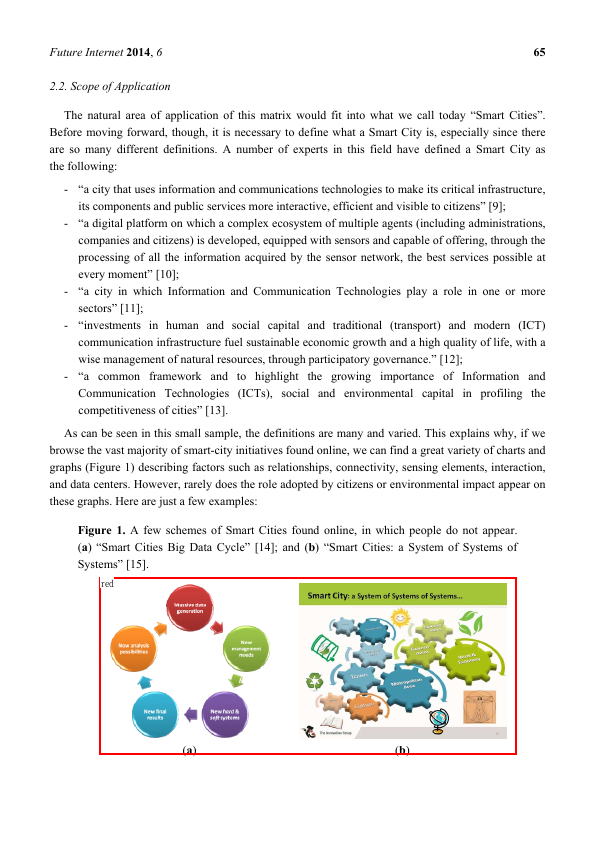

Page number 5
Figure Table Service predictions


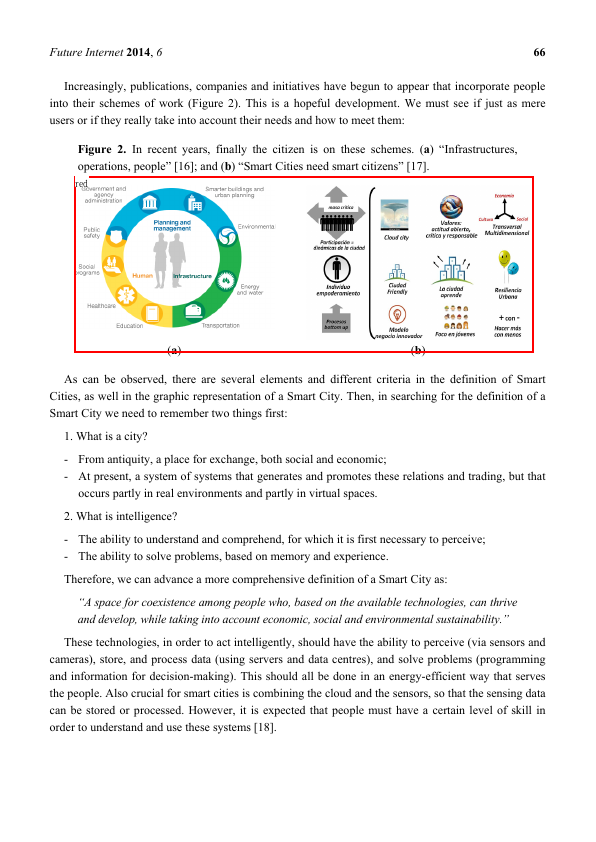

Page number 6
Figure Table Service predictions


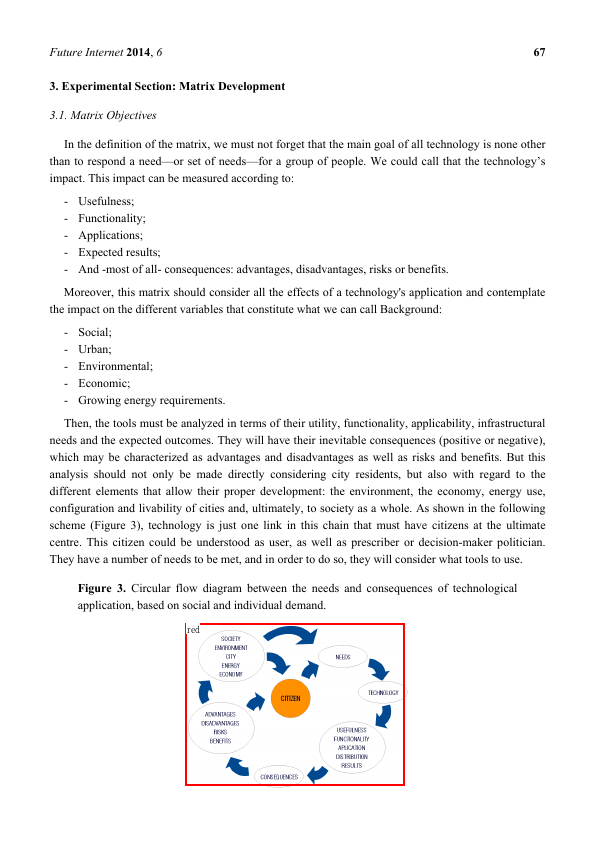

Page number 7
Figure Table Service predictions


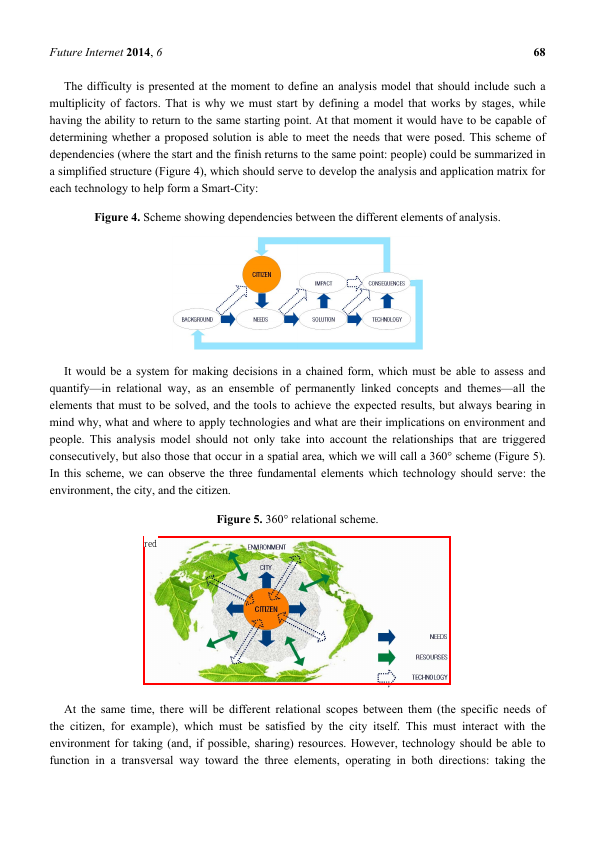

Page number 8
Figure Table Service predictions


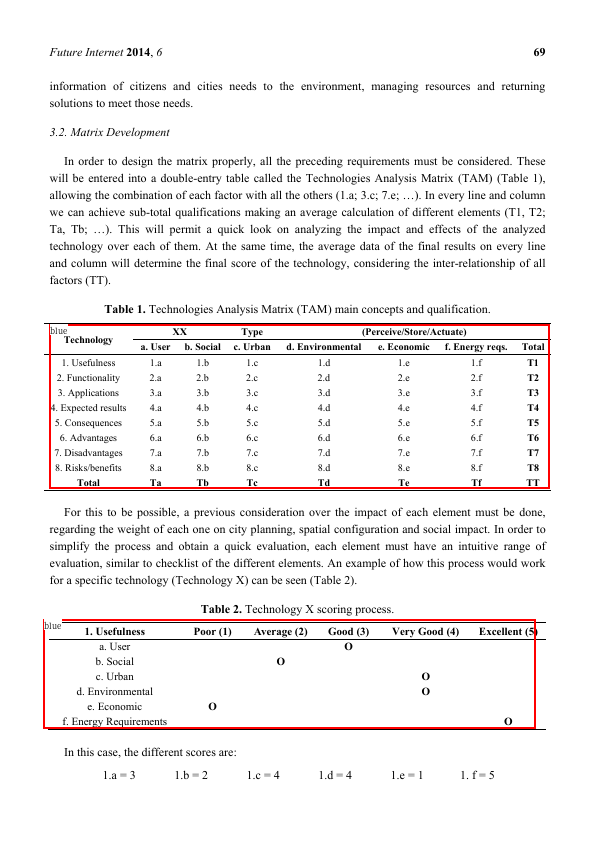

Page number 9
Figure Table Service predictions


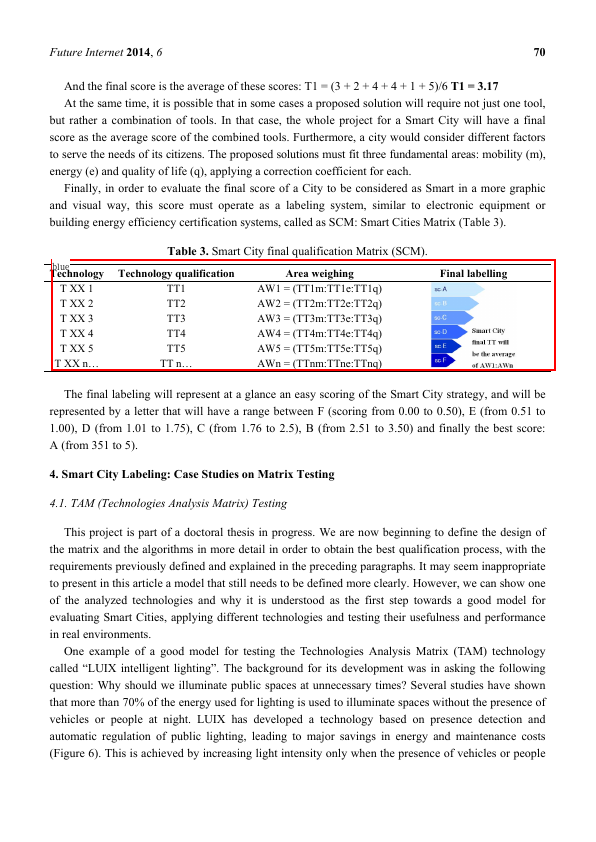

Page number 10
Figure Table Service predictions


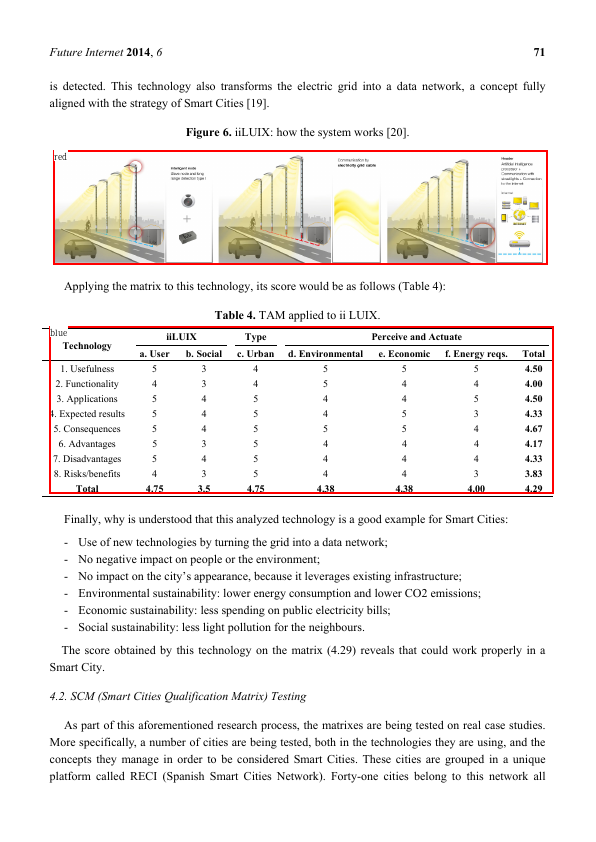

Page number 11
Figure Table Service predictions


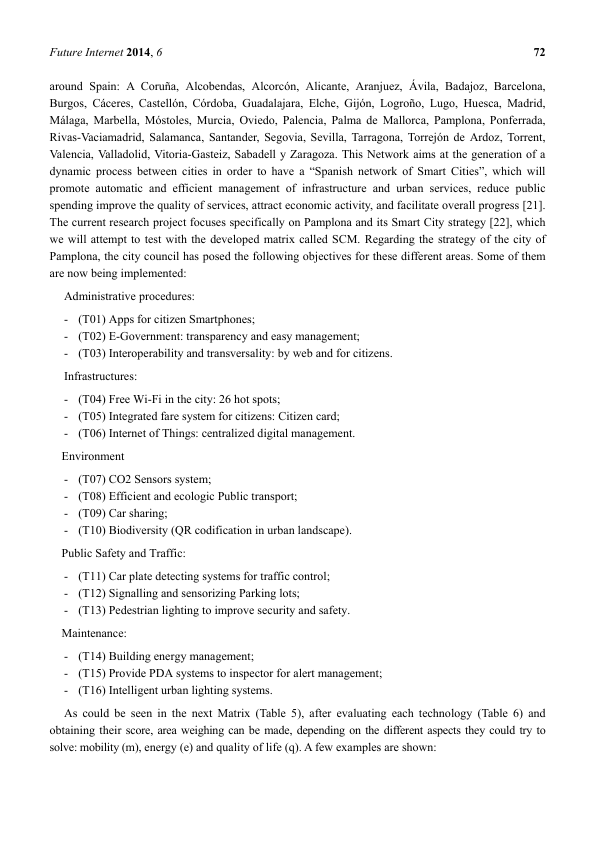

Page number 12
Figure Table Service predictions


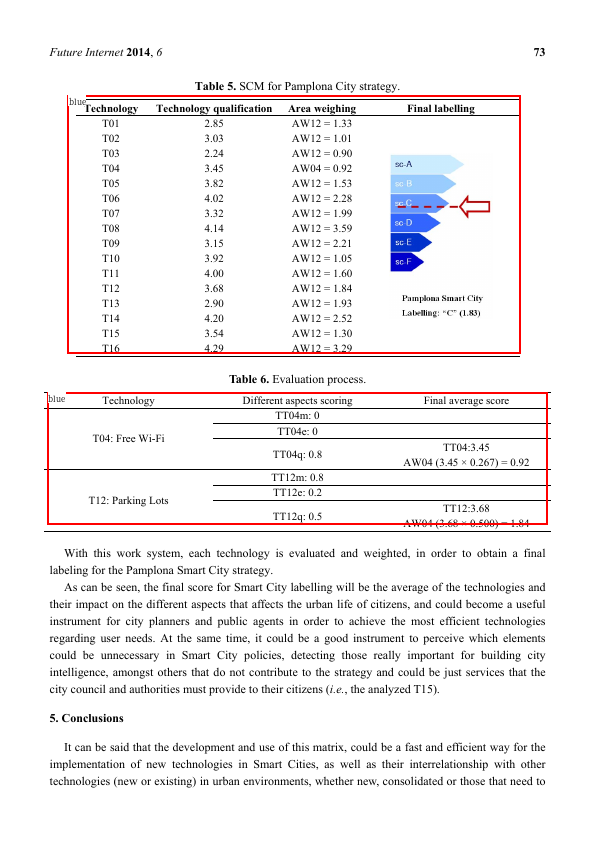

Page number 13
Figure Table Service predictions


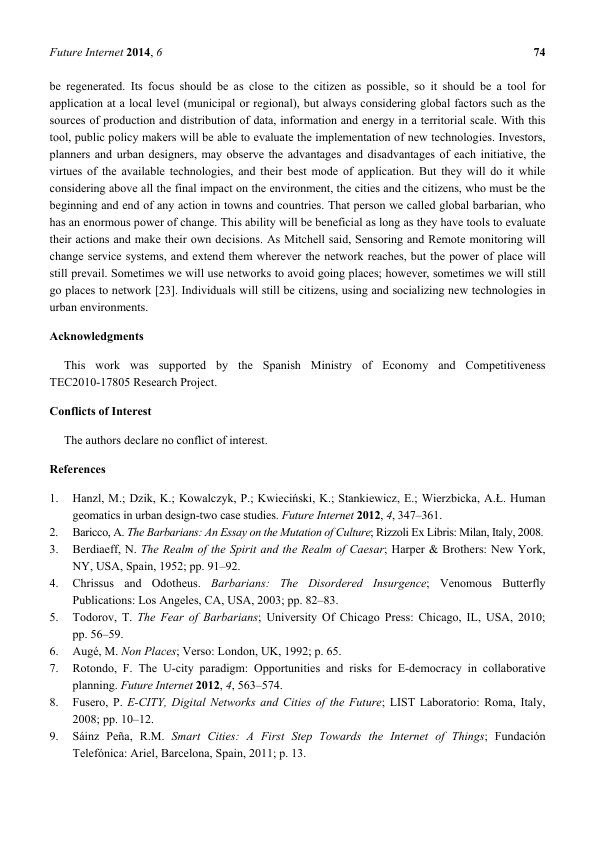

Page number 14
Figure Table Service predictions


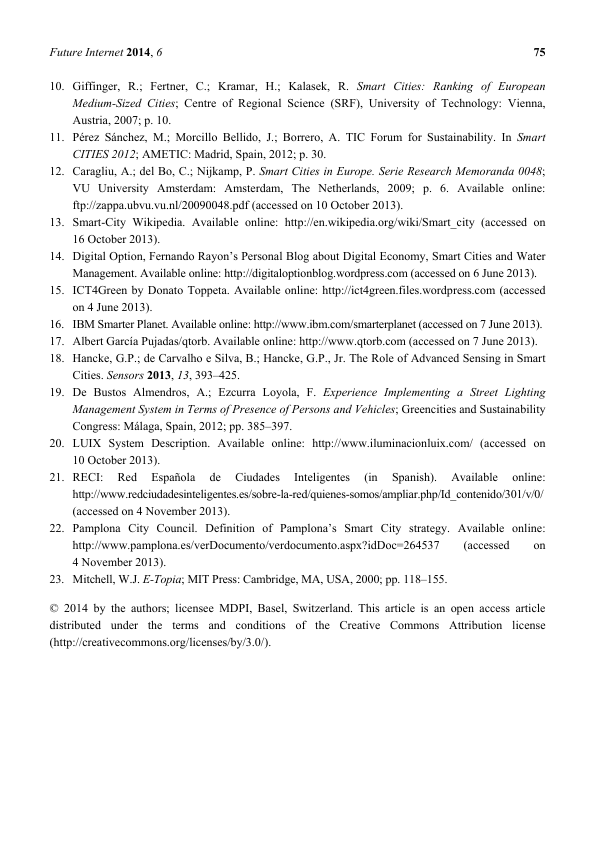

In [47]:
generate_mmda_figure_table_pdf(doc, figure_box_groups, table_box_groups, 
                               figure_caption_span_groups, table_caption_span_groups, display_=False)

## Direct calls to the MMDA (not using local service)

In [269]:
from mmda.predictors.heuristic_predictors.figure_table_predictors import FigureTablePredictions

In [270]:
# In case we need to modify local code for experiments we keep updating it
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [271]:
figure_table_pred = FigureTablePredictions(doc).predict()

  0%|                                                                                                                                                                     | 0/4 [00:00<?, ?it/s]


Figure 1: Circuit and readout timing diagram of 4T CMOS Image Sensor pixel. TG is the transfer gate transistor; CDS1 and CDS2 are
the hold/sample of the Correlated Double Sampling (CDS).
Figure 2: Zoom of a pixel array in low-light level condition showing flickering pixels response due to noise level distribution.
Figure 3: Typical RTS power spectral density (Lorentzian shape) (a) and corresponding relative drain current fluctuations in time domain
(b) observed on the source follower transistor before CDS operation. Three traps are active at the same time.
Figure 4: Equivalent Circuit diagram of 4T CMOS Image Sensor pixel used for the modeling of the temporal output simulation.
Figure 5: Simulated and experimental output noise values of source follower transistors for an usual noise model (1/f noise and themal
noise) and for a noise model including RTS noise.
Figure 6: Input source follower noise power spectral density before and after CDS operation taking into account RTS noise.
Figur

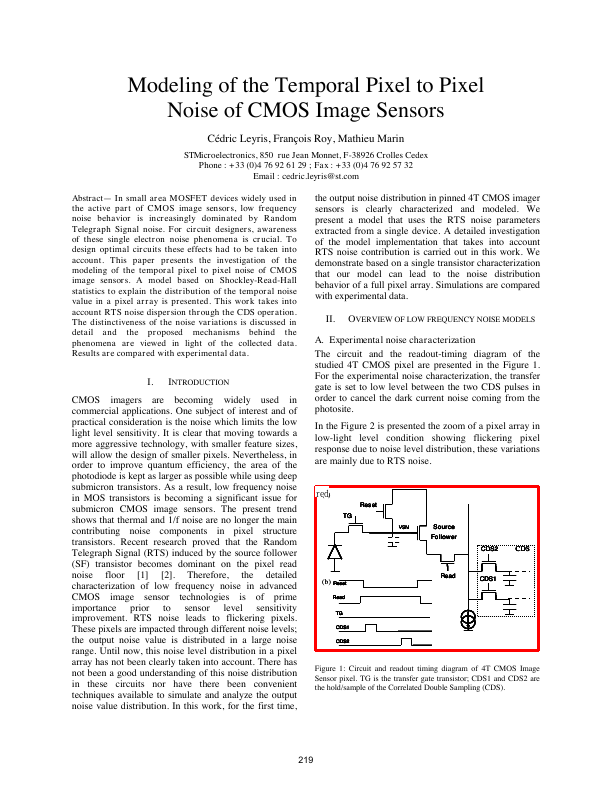

Page number 1
Figure Table Service predictions


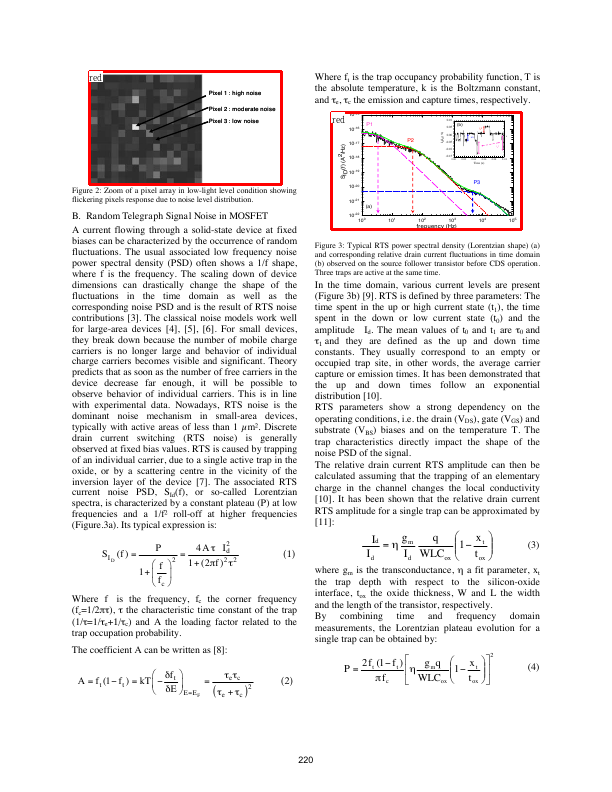

Page number 2
Figure Table Service predictions


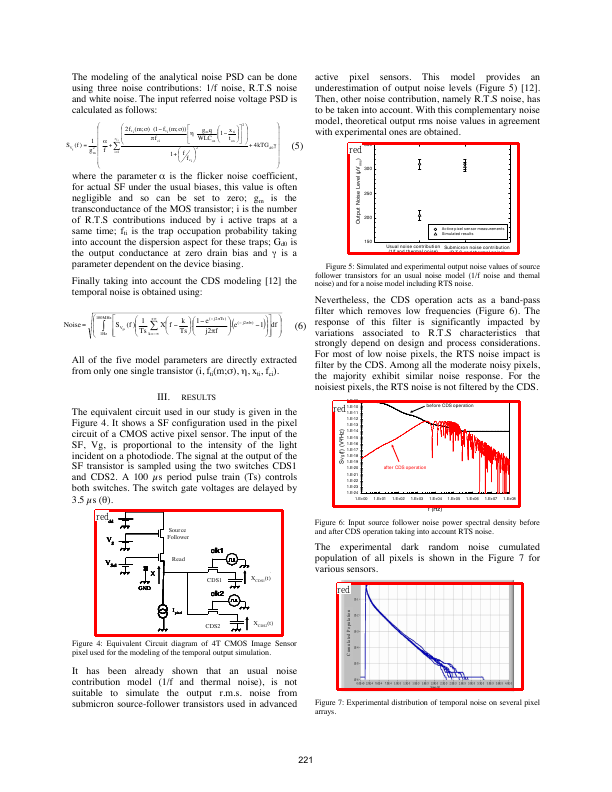

Page number 3
Figure Table Service predictions


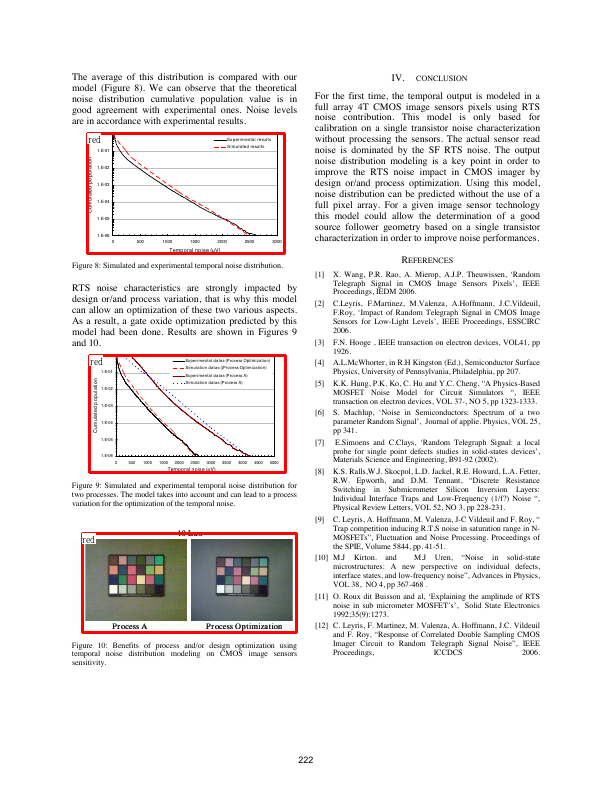

In [272]:
generate_mmda_figure_table_pdf(doc, figure_table_pred['figures'], figure_table_pred['tables'], figure_table_pred['figure_captions'], 
                               figure_table_pred['table_captions'], display_=False)